## 2）是否能预测未联系客服的消费者中，多少比例的消费者可能因客服联系而留存？如果客服联系这些消费者，首次外卖超时且超时30分钟以上的消费者留存率预期会提高多少？

In [4]:
import pandas as pd
import numpy as np

# 读取并展示数据
data = pd.read_csv(r'customer_data.csv')
data

,User_id,User_os,Register_days,Last_order_date,Is_contact_customer_service,Order_frequency,Average_order_amount,Coupon_Usage_Count,Average_discount_ratio_per_order,Is_90days_repurchase
0,770487,Android,525,2023/8/1,0,41,44.65,41,0.0680,0
1,216739,iOS,263,2023/8/1,0,13,43.15,13,0.0364,0
2,126225,iOS,630,2023/8/1,1,117,52.19,117,0.1548,1
3,877572,iOS,221,2023/8/1,0,1,65.05,1,0.0629,0
4,388389,Android,215,2023/8/1,0,1,35.75,1,0.1790,0
...,...,...,...,...,...,...,...,...,...,...
125030,690620,Android,200,2023/8/31,0,65,99.69,65,0.0326,0
125031,643902,iOS,806,2023/8/31,0,272,40.73,272,0.1024,1
125032,599097,Android,673,2023/8/31,0,111,49.75,111,0.1896,1
125033,829897,iOS,705,2023/8/31,1,119,51.80,119,0.6413,1


要分析有多少比例消费者可能因客服联系而留存，首先我们发现主动联系客服和客服主动联系消费者都导向获取优惠券，所以可以将消费者主动联系客服与客服联系消费者归为同一个变量，即该模型中的干预变量。

同时，我们假设所有混淆变量都已出现在数据中。在这个情况下，我们可以通过双重机器学习模型（随机森林）进行建模，以消除混淆变量X的影响，直接建模出干预变量T（是否有客服介入）对结果变量Y（是否留存）的影响。

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from econml.dml import CausalForestDML
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. 设置特征与变量
features = ['Register_days', 'Order_frequency', 'Average_order_amount',
            'Coupon_Usage_Count', 'Average_discount_ratio_per_order']
X = data[features]
T = data['Is_contact_customer_service']  # 干预变量
Y = data['Is_90days_repurchase']         # 结果变量

# 2. 特征标准化（对森林不是必要，但对模型稳定性有好处）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. 拆分数据
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X_scaled, T, Y, test_size=0.2, random_state=42
)

# 4. 构建 DML 模型，双随机森林
model_y = RandomForestRegressor(n_estimators=100, random_state=42)
model_t = RandomForestClassifier(n_estimators=100, random_state=42)

cf_dml = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    discrete_treatment=True,
    random_state=42
)
# 5. 拟合模型
cf_dml.fit(Y_train, T_train, X=X_train)

# 预测个体uplift
te_pred = cf_dml.effect(X_test)

# 7. 构建结果表格
results_df = pd.DataFrame(X_test, columns=features)
results_df['uplift'] = te_pred
results_df['T'] = T_test.reset_index(drop=True)
results_df['Y'] = Y_test.reset_index(drop=True)
results_df.head()

,Register_days,Order_frequency,Average_order_amount,Coupon_Usage_Count,Average_discount_ratio_per_order,uplift,T,Y
0,-0.771529,-0.738943,0.742089,-0.738855,-0.755462,0.077372,0,0
1,0.403338,-0.738943,-0.453038,-0.738855,-1.012828,0.684845,1,1
2,-1.259678,-0.568429,-0.583614,-0.568341,-0.461963,0.376339,0,1
3,0.022747,-0.738943,-0.340836,-0.738855,-0.226149,0.072192,0,0
4,-0.255801,-0.353043,-0.807627,-0.352954,0.099045,0.538168,1,0


已完成建模并成功输出个体的因果效应表格

接下来输出所有消费者的因果效应表格

In [38]:
# 全量预测 uplift
uplift_all = cf_dml.effect(X_scaled)

# 构建完整结果 DataFrame
results_df = pd.DataFrame(X_scaled, columns=X.columns)
results_df['uplift'] = uplift_all
results_df['T'] = T.reset_index(drop=True)
results_df['Y'] = Y.reset_index(drop=True)
results_df

,Register_days,Order_frequency,Average_order_amount,Coupon_Usage_Count,Average_discount_ratio_per_order,uplift,T,Y
0,-0.115148,-0.379966,-0.368397,-0.379877,-0.721865,0.425029,0,0
1,-0.837719,-0.631250,-0.397719,-0.631162,-0.922179,0.356199,0,0
2,0.174432,0.302091,-0.221010,0.302180,-0.171634,0.009003,1,1
3,-0.953550,-0.738943,0.030369,-0.738855,-0.754194,0.023892,0,0
4,-0.970098,-0.738943,-0.542369,-0.738855,-0.018228,0.213187,0,0
...,...,...,...,...,...,...,...,...
125030,-1.011466,-0.164580,0.707490,-0.164491,-0.946267,0.463542,0,0
125031,0.659823,1.693128,-0.445023,1.693219,-0.503801,-0.460531,0,1
125032,0.293022,0.248244,-0.268706,0.248333,0.048966,0.009359,0,1
125033,0.381274,0.320040,-0.228634,0.320129,2.912322,0.323637,1,1


在这之后我们可以计算出未联系客服消费者的upflit值（P(Y=1|T=1,X=x)−P(Y=1|T=0,X=x))，uplift大于0的消费者可能因客服联系而留存，而未联系客服的消费者占40%，据此计算出其中可能因客服联系而留存的比例。

In [39]:
# 找出未联系客服的用户
untreated = results_df[results_df['T'] == 0]

# 在未联系客服的人中，找出 uplift > 0 的（表示如果联系可能留存）
uplift_positive = untreated[untreated['uplift'] > 0]

# 计算比例与数量
positive_ratio = len(uplift_positive) / len(untreated)
positive_count = len(uplift_positive)
total_untreated = len(untreated)

print(f"未联系客服的用户中，uplift > 0 的占比为：{positive_ratio:.2%}")

未联系客服的用户中，uplift > 0 的占比为：78.51%


说明未主动联系客服的用户中，有78.51%可能因客服联系而留存

而要预测留存率提升预期，我们先计算在不联系这些消费者的前提下，首次外卖超时且超时30分钟以上的消费者的平均留存率。再计算客服联系这些消费者的前提下，首次外卖超时且超时30分钟以上的消费者的平均留存率，再由后者减去前者，即留存率的预期提高值。  
更简单来说，对未联系客服（T=0）但 uplift > 0 的用户，计算他们的平均 uplift 值，即预期整体提升的留存率。

In [40]:
# 2. 计算这部分人 uplift 的总和（≈ 预期总提升的留存人数）
total_expected_retained = uplift_positive['uplift'].sum()

# 3. 用全体用户数作为分母
total_users = len(results_df)

# 4. 计算对全体用户的留存率提升比例
global_uplift_rate = total_expected_retained / total_users

# 5. 输出
print(f"假设联系了未主动联系客服但uplift>0的消费者（人数{len(uplift_positive)}人）")
print(f"对首次外卖超时且超时30分钟以上的消费者留存率的预期提升为：{global_uplift_rate:.2%}")
print(f"等价于多留存约 {total_expected_retained:.0f} 人")

假设联系了未主动联系客服但uplift>0的消费者（人数58151人）
对首次外卖超时且超时30分钟以上的消费者留存率的预期提升为：19.22%
等价于多留存约 24029 人


In [ ]:
观察发现留存率提升值异常偏高，考虑绘制uplift图观察分布

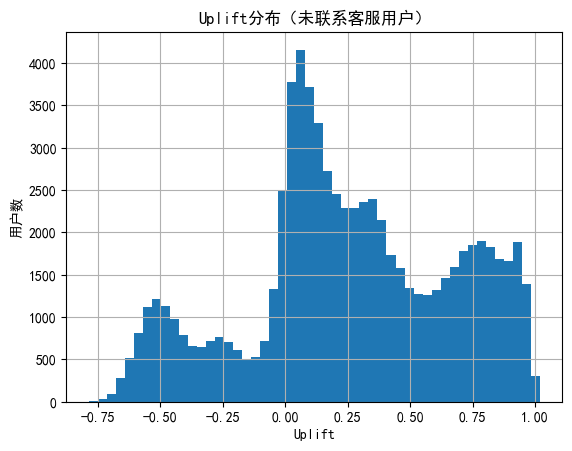

In [42]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
untreated['uplift'].hist(bins=50)
plt.title("Uplift分布（未联系客服用户）")
plt.xlabel("Uplift")
plt.ylabel("用户数")
plt.show()

由图可得，有大量用户uplift值大于0但非常接近0，在3）中预测时考虑对uplift设置阈值

# 结论：
#### 未联系客服消费者中，有78.51%可能因客服联系而留存。
#### 如果客服联系这些消费者，首次外卖超时且超时30分钟以上的消费者留存率预期会提高19.22%。

## 3）需考虑客服成本的问题，客服不会联系会自然留存的消费者。分析一批刚遇到外卖超时且超时30分钟的消费者（customer_data_forecast）中多少比例的消费者会自然留存？剩余多少比例的消费者需要客服主动联系？

方案1：使用2）中的对于T | X 与Y | X的模型（设置概率阈值为0.5），预测Y与T的值，并用DML模型求uplift。将结果分成以下几类：  
一. 未联系且未留存（T=0, Y=0）情况，    
  1. uplift>0则需要客服主动联系  
  2. uplift<0说明对干预不敏感；  
二. 联系且留存（T=1, Y=1）情况，自然留存；  
三. 未联系但留存（T=0，Y=1），自然留存；  
四. 联系但不留存（T=1，Y=0）情况，其他。  
其中二三两种为自然留存的消费者，一（a）为需要主动联系的消费者。 

In [45]:
data2 = pd.read_csv(r'customer_data_forecast.csv')
data2

,User_id,User_os,Register_days,Last_order_date,Is_contact_customer_service,Order_frequency,Average_order_amount,Coupon_Usage_Count,Average_discount_ratio_per_order
0,2867825,Android,355,2024-01-01,0,44,163.67,44,0.0621
1,1419610,iOS,1310,2024-01-01,0,114,161.15,114,0.0666
2,5614226,Android,659,2024-01-01,0,3,14.93,3,0.1400
3,5108603,Android,534,2024-01-01,0,41,88.92,41,0.0411
4,4744854,Android,536,2024-01-01,0,57,18.85,57,0.3017
...,...,...,...,...,...,...,...,...,...
62033,2983340,Android,1319,2024-01-31,0,1,78.16,1,0.0447
62034,9281631,Android,1290,2024-01-31,0,74,54.06,74,0.1845
62035,4934990,iOS,218,2024-01-31,0,1,49.22,1,0.1567
62036,9023088,Android,1368,2024-01-31,0,165,80.42,165,0.0480


In [46]:
X2 = data2[features]
X2_scaled = scaler.transform(X2)
uplift_all = cf_dml.effect(X2_scaled)
results_df2 = pd.DataFrame(X2_scaled, columns=X2.columns)
results_df2['uplift'] = uplift_all
results_df2['T'] = T.reset_index(drop=True)
results_df2['Y'] = Y.reset_index(drop=True)
results_df2

,Register_days,Order_frequency,Average_order_amount,Coupon_Usage_Count,Average_discount_ratio_per_order,uplift,T,Y
0,-0.583991,-0.353043,1.958131,-0.352954,-0.759265,0.063172,0,0
1,2.049806,0.275167,1.908872,0.275257,-0.730739,0.120969,0,0
2,0.254411,-0.720995,-0.949346,-0.720906,-0.265452,0.667883,1,1
3,-0.090327,-0.379966,0.496965,-0.379877,-0.892385,0.046934,0,0
4,-0.084811,-0.236375,-0.872720,-0.236286,0.759575,0.835784,0,0
...,...,...,...,...,...,...,...,...
62033,2.074627,-0.738943,0.286635,-0.738855,-0.869565,0.127626,0,0
62034,1.994647,-0.083810,-0.184457,-0.083721,0.016637,-0.238124,0,1
62035,-0.961824,-0.738943,-0.279066,-0.738855,-0.159589,0.330389,0,0
62036,2.209764,0.732863,0.330812,0.732953,-0.848646,0.089784,1,0


接下来我们找出会自然留存的消费者
（联系且留存（T=1, Y=1）情况，自然留存；
未联系但留存（T=0，Y=1），自然留存；）

In [48]:
treated_retained = results_df[(results_df['T'] == 1) & (results_df['Y'] == 1)]
untreated_retained = results_df[(results_df['T'] == 0) & (results_df['Y'] == 1)]
natural_retained = pd.concat([treated_retained, untreated_retained])

natural_retained_ratio = len(natural_retained) / len(results_df)
print(f"会自然留存的消费者占比为：{natural_retained_ratio:.2%}")

会自然留存的消费者占比为：43.03%


然后找出需要客服主动联系的消费者

In [56]:
# 找出未联系客服的用户
untreated2 = results_df2[results_df2['T'] == 0 ]

# 在未联系客服的人中，找出 uplift > 0 的（表示如果联系可能留存）
uplift_positive = untreated2[untreated2['uplift'] > 0]
positive_ratio = len(uplift_positive) / len(untreated2)
positive_count = len(uplift_positive)
total_untreated = len(untreated)
rate2 = len(uplift_positive) / len(results_df2)
print(f"未联系客服的用户中，uplift > 0 的占比为：{positive_ratio:.2%}")
print(f"占所有用户比例为：{rate2:.2%}")

未联系客服的用户中，uplift > 0 的占比为：80.17%
占所有用户比例为：47.52%


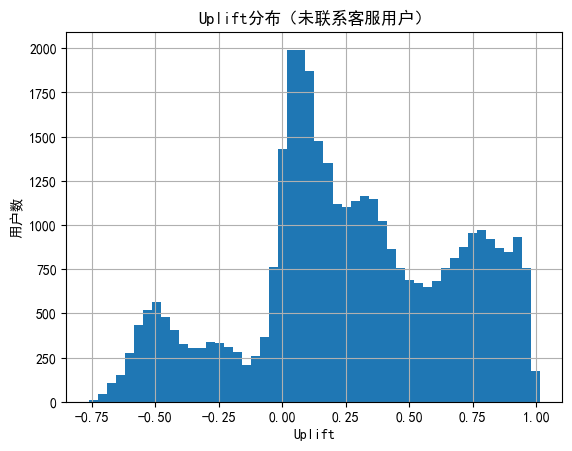

In [54]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
untreated2['uplift'].hist(bins=50)
plt.title("Uplift分布（未联系客服用户）")
plt.xlabel("Uplift")
plt.ylabel("用户数")
plt.show()

进一步考虑成本问题，找出可能因客服联系而留存的消费者中一部分有高留存概率的消费者，那么我们考虑设置uplift阈值

In [72]:
# 找出未联系客服的用户
untreated2 = results_df2[results_df2['T'] == 0 ]

# 在未联系客服的人中，找出 uplift > 0 的（表示如果联系可能留存）
uplift_positive = untreated2[untreated2['uplift'] > 0.25]
positive_ratio = len(uplift_positive) / len(untreated2)
positive_count = len(uplift_positive)
total_untreated = len(untreated)
rate2 = len(uplift_positive) / len(results_df2)
print(f"未联系客服的用户中，uplift > 0 的占比为：{positive_ratio:.2%}")
print(f"占所有用户比例为：{rate2:.2%}")

未联系客服的用户中，uplift > 0 的占比为：49.64%
占所有用户比例为：29.42%


# 结论：
#### 这批消费者中有43.03%会自然留存，剩下29.42%需要客服主动联系。